# FD004 Simple Universal V2 HI Diagnostics

This notebook is a **minimal, end-to-end FD004 pipeline** for the `universal_v2_ms_cnn` model:

- Data loading & feature engineering
- Sequence building
- Model definition & (optional) training
- Test inference
- HI & RUL trajectories for 10 engines
- Simple diagnostics (RMSE, NASA, histograms, scatter)

**Key design:** This notebook is self-contained and does NOT depend on `run_experiments.py` or the `diagnostics.py` stack. All control flow is explicit in the notebook cells.


In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# Repo imports
import sys
sys.path.insert(0, '..')

from src.data_loading import load_cmapps_subset
from src.additional_features import (
    create_physical_features,
    create_all_features,
    FeatureConfig,
    TemporalFeatureConfig,
    PhysicsFeatureConfig,
)
from src.feature_safety import remove_rul_leakage
from src.eol_full_lstm import (
    build_full_eol_sequences_from_df,
    build_test_sequences_from_df,
)
from src.metrics import compute_eol_errors_and_nasa, nasa_phm_score_single
from src.models.universal_encoder_v1 import UniversalEncoderV2, RULHIUniversalModelV2

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


Using device: cpu


In [2]:
# Load FD004 train/test
dataset_name = "FD004"
df_train, df_test, y_test_true = load_cmapps_subset(
    dataset_name,
    max_rul=None,
    clip_train=False,
    clip_test=True,
)

print(f"Train: {len(df_train)} rows, {df_train['UnitNumber'].nunique()} engines")
print(f"Test: {len(df_test)} rows, {df_test['UnitNumber'].nunique()} engines")
print(f"Test RUL file: {len(y_test_true)} values")

# Feature engineering (same as Phase 3)
physics_config = PhysicsFeatureConfig(
    use_core=True,
    use_extended=False,
    use_residuals=False,
    use_temporal_on_physics=False,
)
feature_config = FeatureConfig(
    add_physical_core=True,
    add_temporal_features=True,
    temporal=TemporalFeatureConfig(
        base_cols=None,
        short_windows=(5, 10),
        long_windows=(30,),
        add_rolling_mean=True,
        add_rolling_std=False,
        add_trend=True,
        add_delta=True,
        delta_lags=(5, 10),
    ),
)

df_train_fe = create_physical_features(df_train.copy(), physics_config, "UnitNumber", "TimeInCycles")
df_train_fe = create_all_features(df_train_fe, "UnitNumber", "TimeInCycles", feature_config, inplace=False)

df_test_fe = create_physical_features(df_test.copy(), physics_config, "UnitNumber", "TimeInCycles")
df_test_fe = create_all_features(df_test_fe, "UnitNumber", "TimeInCycles", feature_config, inplace=False)

# Build feature columns
feature_cols = [
    c for c in df_train_fe.columns
    if c not in ["UnitNumber", "TimeInCycles", "RUL", "RUL_raw", "MaxTime", "ConditionID"]
]
feature_cols, _ = remove_rul_leakage(feature_cols)
print(f"Num features: {len(feature_cols)}")


[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
Train: 61249 rows, 249 engines
Test: 41214 rows, 248 engines
Test RUL file: 248 values
Num features: 244


In [3]:
# Sequence building parameters (same as fd004_phase3_universal_v2_ms_cnn)
past_len = 30
max_rul = 125

# Build full EOL sequences from train data
X_full, y_full, unit_ids_full, cond_ids_full = build_full_eol_sequences_from_df(
    df=df_train_fe,
    feature_cols=feature_cols,
    past_len=past_len,
    max_rul=max_rul,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    rul_col="RUL",
    cond_col="ConditionID",
)

print(f"Full sequences: X={X_full.shape}, y={y_full.shape}, units={unit_ids_full.shape}, conds={cond_ids_full.shape}")

# Simple engine-based split (80/20)
unique_units = np.unique(unit_ids_full.numpy())
n_total = len(unique_units)
n_train = int(0.8 * n_total)
train_units = unique_units[:n_train]
val_units = unique_units[n_train:]

print(f"Train engines: {len(train_units)}, Val engines: {len(val_units)}")

train_mask = np.isin(unit_ids_full.numpy(), train_units)
val_mask = np.isin(unit_ids_full.numpy(), val_units)

X_train = X_full[train_mask]
y_train = y_full[train_mask]
cond_train = cond_ids_full[train_mask]

X_val = X_full[val_mask]
y_val = y_full[val_mask]
cond_val = cond_ids_full[val_mask]

print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Val: X={X_val.shape}, y={y_val.shape}")

# Build test sequences (EOL windows only)
X_test, unit_ids_test, cond_ids_test = build_test_sequences_from_df(
    df_test_fe,
    feature_cols=feature_cols,
    past_len=past_len,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
)

print(f"Test: X={X_test.shape}, units={unit_ids_test.shape}, conds={cond_ids_test.shape}")


[build_full_eol_sequences_from_df] Summary
Num units: 249
Using past_len=30, max_rul=125
Num feature cols: 244
X shape: torch.Size([54028, 30, 244]), y shape: torch.Size([54028]), unit_ids shape: torch.Size([54028]), cond_ids shape: torch.Size([54028])
RUL stats (capped at 125): min=0.00, max=125.00, mean=88.73, std=41.48
ConditionIDs: [0, 1, 2, 3, 4, 5, 6]
Full sequences: X=torch.Size([54028, 30, 244]), y=torch.Size([54028]), units=torch.Size([54028]), conds=torch.Size([54028])
Train engines: 199, Val engines: 50
Train: X=torch.Size([43301, 30, 244]), y=torch.Size([43301])
Val: X=torch.Size([10727, 30, 244]), y=torch.Size([10727])
[build_test_sequences_from_df] Summary
Num test units: 248
Using past_len=30
Num feature cols requested: 244
Num feature cols available: 244
X shape: torch.Size([248, 30, 244]), unit_ids shape: torch.Size([248]), cond_ids shape: torch.Size([248])
ConditionIDs: [0, 1, 2, 3, 4, 5, 6]
Test: X=torch.Size([248, 30, 244]), units=torch.Size([248]), conds=torch.Size

In [4]:
# Condition-wise feature scaling (same as training)
scaler_dict = {}
all_cond_ids = np.unique(cond_train.numpy())

X_train_np = X_train.numpy()
X_val_np = X_val.numpy()
X_test_np = X_test.numpy()

X_train_scaled = np.empty_like(X_train_np)
X_val_scaled = np.empty_like(X_val_np)
X_test_scaled = np.empty_like(X_test_np)

for cond in all_cond_ids:
    cond = int(cond)
    train_mask_cond = (cond_train.numpy() == cond)
    val_mask_cond = (cond_val.numpy() == cond)
    test_mask_cond = (cond_ids_test.numpy() == cond)
    
    scaler = StandardScaler()
    # Fit on train data for this condition
    X_train_cond_flat = X_train_np[train_mask_cond].reshape(-1, X_train_np.shape[-1])
    scaler.fit(X_train_cond_flat)
    scaler_dict[cond] = scaler
    
    # Transform train
    if train_mask_cond.any():
        X_train_scaled[train_mask_cond] = scaler.transform(
            X_train_np[train_mask_cond].reshape(-1, X_train_np.shape[-1])
        ).reshape(-1, past_len, len(feature_cols))
    
    # Transform val
    if val_mask_cond.any():
        X_val_scaled[val_mask_cond] = scaler.transform(
            X_val_np[val_mask_cond].reshape(-1, X_val_np.shape[-1])
        ).reshape(-1, past_len, len(feature_cols))
    
    # Transform test
    if test_mask_cond.any():
        X_test_scaled[test_mask_cond] = scaler.transform(
            X_test_np[test_mask_cond].reshape(-1, X_test_np.shape[-1])
        ).reshape(-1, past_len, len(feature_cols))

print(f"Scaled features for {len(scaler_dict)} conditions: {sorted(scaler_dict.keys())}")

# Convert to tensors and move to device
X_train_t = torch.from_numpy(X_train_scaled).float().to(device)
y_train_t = y_train.float().to(device)
cond_train_t = cond_train.to(device)

X_val_t = torch.from_numpy(X_val_scaled).float().to(device)
y_val_t = y_val.float().to(device)
cond_val_t = cond_val.to(device)

X_test_t = torch.from_numpy(X_test_scaled).float().to(device)
cond_test_t = cond_ids_test.to(device)


Scaled features for 7 conditions: [0, 1, 2, 3, 4, 5, 6]


In [5]:
# Model definition (same as fd004_phase3_universal_v2_ms_cnn)
input_dim = X_train_scaled.shape[-1]
num_conditions = int(cond_ids_full.max().item()) + 1
cond_emb_dim = 4
d_model = 64
nhead = 4
num_layers = 3
dim_feedforward = 256  # 4 * d_model
dropout = 0.1
kernel_sizes = [3, 5, 9]
seq_encoder_type = "transformer"
use_layer_norm = True

encoder = UniversalEncoderV2(
    input_dim=input_dim,
    d_model=d_model,
    num_layers=num_layers,
    nhead=nhead,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    num_conditions=num_conditions,
    cond_emb_dim=cond_emb_dim,
    max_seq_len=300,
    kernel_sizes=kernel_sizes,
    seq_encoder_type=seq_encoder_type,
    use_layer_norm=use_layer_norm,
)

model = RULHIUniversalModelV2(
    encoder=encoder,
    d_model=d_model,
    dropout=dropout,
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {total_params:,} total parameters, {trainable_params:,} trainable")


Model: 306,302 total parameters, 306,302 trainable


Epoch 1/10: train_loss=5900.3974, val_loss=2866.6236, val_rmse=53.54
Epoch 5/10: train_loss=303.9914, val_loss=626.1180, val_rmse=25.01
Epoch 10/10: train_loss=192.3493, val_loss=608.6070, val_rmse=24.66
Best model from epoch 7 with val_loss=581.4094


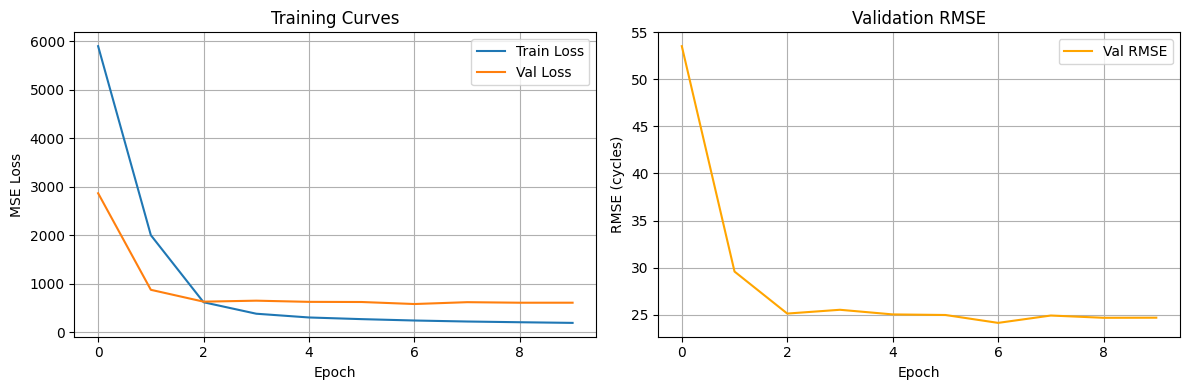

In [6]:
# Simple training loop (MSE on RUL only, for simplicity)
batch_size = 256
num_epochs = 10
patience = 10
lr = 1e-4
weight_decay = 1e-4

# DataLoaders
train_ds = TensorDataset(X_train_t, y_train_t, cond_train_t)
val_ds = TensorDataset(X_val_t, y_val_t, cond_val_t)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Training history
train_losses = []
val_losses = []
val_rmses = []
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss_epoch = 0.0
    for X_batch, y_batch, cond_batch in train_loader:
        optimizer.zero_grad()
        
        # Forward
        rul_pred, hi_last, hi_seq = model(X_batch, cond_ids=cond_batch)
        rul_pred = rul_pred.squeeze(-1) if rul_pred.dim() > 1 else rul_pred
        
        # Loss (simple MSE on RUL)
        loss = nn.functional.mse_loss(rul_pred, y_batch)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        train_loss_epoch += loss.item()
    
    train_loss_epoch /= len(train_loader)
    train_losses.append(train_loss_epoch)
    
    # Validation
    model.eval()
    val_loss_epoch = 0.0
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch, cond_batch in val_loader:
            rul_pred, _, _ = model(X_batch, cond_ids=cond_batch)
            rul_pred = rul_pred.squeeze(-1) if rul_pred.dim() > 1 else rul_pred
            
            loss = nn.functional.mse_loss(rul_pred, y_batch)
            val_loss_epoch += loss.item()
            
            val_preds.append(rul_pred.cpu().numpy())
            val_targets.append(y_batch.cpu().numpy())
    
    val_loss_epoch /= len(val_loader)
    val_losses.append(val_loss_epoch)
    
    # Compute RMSE
    val_preds_all = np.concatenate(val_preds)
    val_targets_all = np.concatenate(val_targets)
    val_rmse = np.sqrt(np.mean((val_preds_all - val_targets_all) ** 2))
    val_rmses.append(val_rmse)
    
    # Early stopping
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        best_epoch = epoch
        patience_counter = 0
        # Save best model state
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: train_loss={train_loss_epoch:.4f}, "
              f"val_loss={val_loss_epoch:.4f}, val_rmse={val_rmse:.2f}")
    
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best model
model.load_state_dict(best_model_state)
print(f"Best model from epoch {best_epoch+1} with val_loss={best_val_loss:.4f}")

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(train_losses, label='Train Loss')
axes[0].plot(val_losses, label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].set_title('Training Curves')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(val_rmses, label='Val RMSE', color='orange')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('RMSE (cycles)')
axes[1].set_title('Validation RMSE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


Test Metrics (EOL-based)
RMSE: 27.46 cycles
MAE:  18.81 cycles
Bias: 4.51 cycles
R²:   0.5917
NASA Score (sum):  18841.92
NASA Score (mean): 75.9755


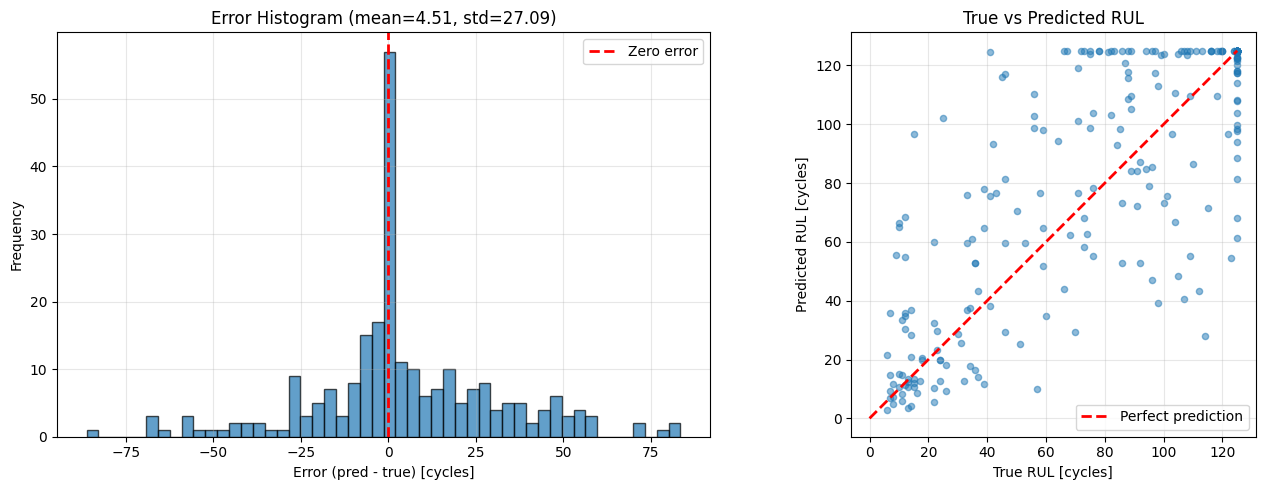

In [7]:
# Test inference and metrics
model.eval()
with torch.no_grad():
    rul_pred_test, hi_last_test, hi_seq_test = model(X_test_t, cond_ids=cond_test_t)

# Convert to numpy and apply capping
rul_pred_np = rul_pred_test.cpu().numpy().flatten()
rul_pred_np = np.clip(rul_pred_np, 0.0, max_rul)

# Build true RUL per engine (map unit_ids_test to y_test_true)
# unit_ids_test is in order, y_test_true is in order of first appearance in test file
unit_ids_test_np = unit_ids_test.numpy()
y_true_eol = np.minimum(y_test_true, max_rul)  # Cap true RUL

# Compute metrics
eol_metrics = compute_eol_errors_and_nasa(y_true_eol, rul_pred_np, max_rul=max_rul)

print("=" * 60)
print("Test Metrics (EOL-based)")
print("=" * 60)
print(f"RMSE: {eol_metrics['rmse']:.2f} cycles")
print(f"MAE:  {eol_metrics['mae']:.2f} cycles")
print(f"Bias: {eol_metrics['bias']:.2f} cycles")
print(f"R²:   {eol_metrics['r2']:.4f}")
print(f"NASA Score (sum):  {eol_metrics['nasa_sum']:.2f}")
print(f"NASA Score (mean): {eol_metrics['nasa_mean']:.4f}")

# Plot diagnostics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error histogram
errors = rul_pred_np - y_true_eol
axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[0].set_xlabel('Error (pred - true) [cycles]')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Error Histogram (mean={errors.mean():.2f}, std={errors.std():.2f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter: true vs pred
axes[1].scatter(y_true_eol, rul_pred_np, alpha=0.5, s=20)
axes[1].plot([0, max_rul], [0, max_rul], 'r--', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel('True RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_title('True vs Predicted RUL')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()


In [8]:
from dataclasses import dataclass

@dataclass
class EngineTrajectory:
    unit_id: int
    cycles: np.ndarray
    hi: np.ndarray
    true_rul: np.ndarray
    pred_rul: np.ndarray

# Build trajectories for all engines
trajectories = []
for i, unit_id in enumerate(unit_ids_test_np):
    unit_id = int(unit_id)
    
    # Get full time series for this engine
    df_engine = df_test_fe[df_test_fe["UnitNumber"] == unit_id].sort_values("TimeInCycles")
    cycles = df_engine["TimeInCycles"].values
    
    if len(cycles) == 0:
        continue
    
    # HI trajectory: use hi_seq_test[i] for last past_len cycles
    hi_seq_engine = hi_seq_test[i].cpu().numpy() if torch.is_tensor(hi_seq_test) else hi_seq_test[i]
    hi_seq_engine = hi_seq_engine.flatten()
    
    # Create full HI trajectory
    hi_traj = np.full(len(cycles), np.nan)
    if len(cycles) >= past_len:
        # Fill last past_len positions with HI sequence
        hi_traj[-past_len:] = hi_seq_engine
        # Forward fill earlier cycles with first HI value
        if len(hi_seq_engine) > 0:
            hi_traj[:len(cycles)-past_len] = hi_seq_engine[0]
    else:
        # If engine is shorter than past_len, use available HI values
        hi_traj[-len(hi_seq_engine):] = hi_seq_engine[:len(cycles)]
        if len(hi_seq_engine) > 0:
            hi_traj[:len(cycles)-len(hi_seq_engine)] = hi_seq_engine[0]
    
    # True RUL trajectory: linear decline from max_rul to true_rul_eol
    true_rul_eol = y_true_eol[i]
    true_rul_traj = np.linspace(max_rul, true_rul_eol, len(cycles))
    
    # Predicted RUL trajectory: constant (simplest version)
    pred_rul_traj = np.full(len(cycles), rul_pred_np[i])
    
    trajectories.append(EngineTrajectory(
        unit_id=unit_id,
        cycles=cycles,
        hi=hi_traj,
        true_rul=true_rul_traj,
        pred_rul=pred_rul_traj,
    ))

print(f"Built trajectories for {len(trajectories)} engines")

# Select 10 engines: 3 early (low true RUL), 3 late (high true RUL), 4 random middle
true_rul_sorted = np.argsort(y_true_eol)
early_indices = true_rul_sorted[:3]
late_indices = true_rul_sorted[-3:]
middle_indices = true_rul_sorted[len(true_rul_sorted)//2-2:len(true_rul_sorted)//2+2]

selected_indices = np.concatenate([early_indices, middle_indices, late_indices])
selected_trajectories = [trajectories[i] for i in selected_indices]

print(f"Selected engines: {[t.unit_id for t in selected_trajectories]}")
print(f"  Early (low RUL): {[trajectories[i].unit_id for i in early_indices]}")
print(f"  Middle: {[trajectories[i].unit_id for i in middle_indices]}")
print(f"  Late (high RUL): {[trajectories[i].unit_id for i in late_indices]}")


Built trajectories for 248 engines
Selected engines: [31, 158, 100, 168, 226, 152, 210, 241, 246, 245]
  Early (low RUL): [31, 158, 100]
  Middle: [168, 226, 152, 210]
  Late (high RUL): [241, 246, 245]


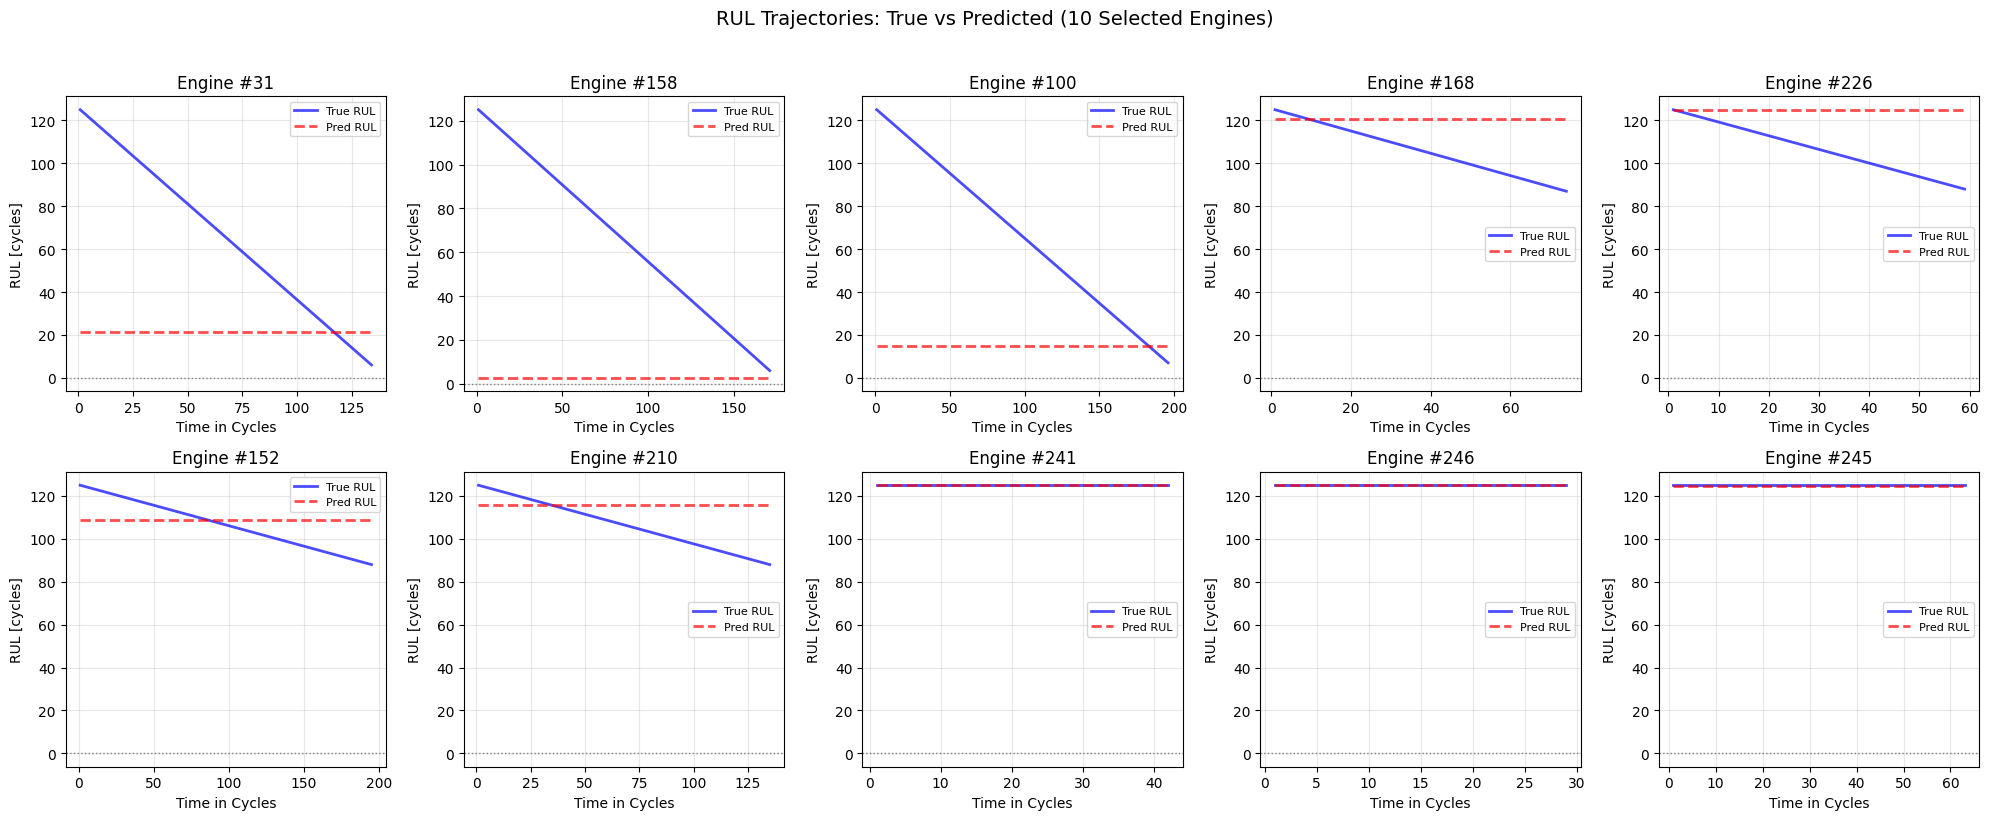

In [9]:
# Plot 1: True vs Pred RUL trajectories
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, traj in enumerate(selected_trajectories):
    ax = axes[idx]
    
    ax.plot(traj.cycles, traj.true_rul, 'b-', linewidth=2, label='True RUL', alpha=0.7)
    ax.plot(traj.cycles, traj.pred_rul, 'r--', linewidth=2, label='Pred RUL', alpha=0.7)
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    
    ax.set_xlabel('Time in Cycles')
    ax.set_ylabel('RUL [cycles]')
    ax.set_title(f'Engine #{traj.unit_id}')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.suptitle('RUL Trajectories: True vs Predicted (10 Selected Engines)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


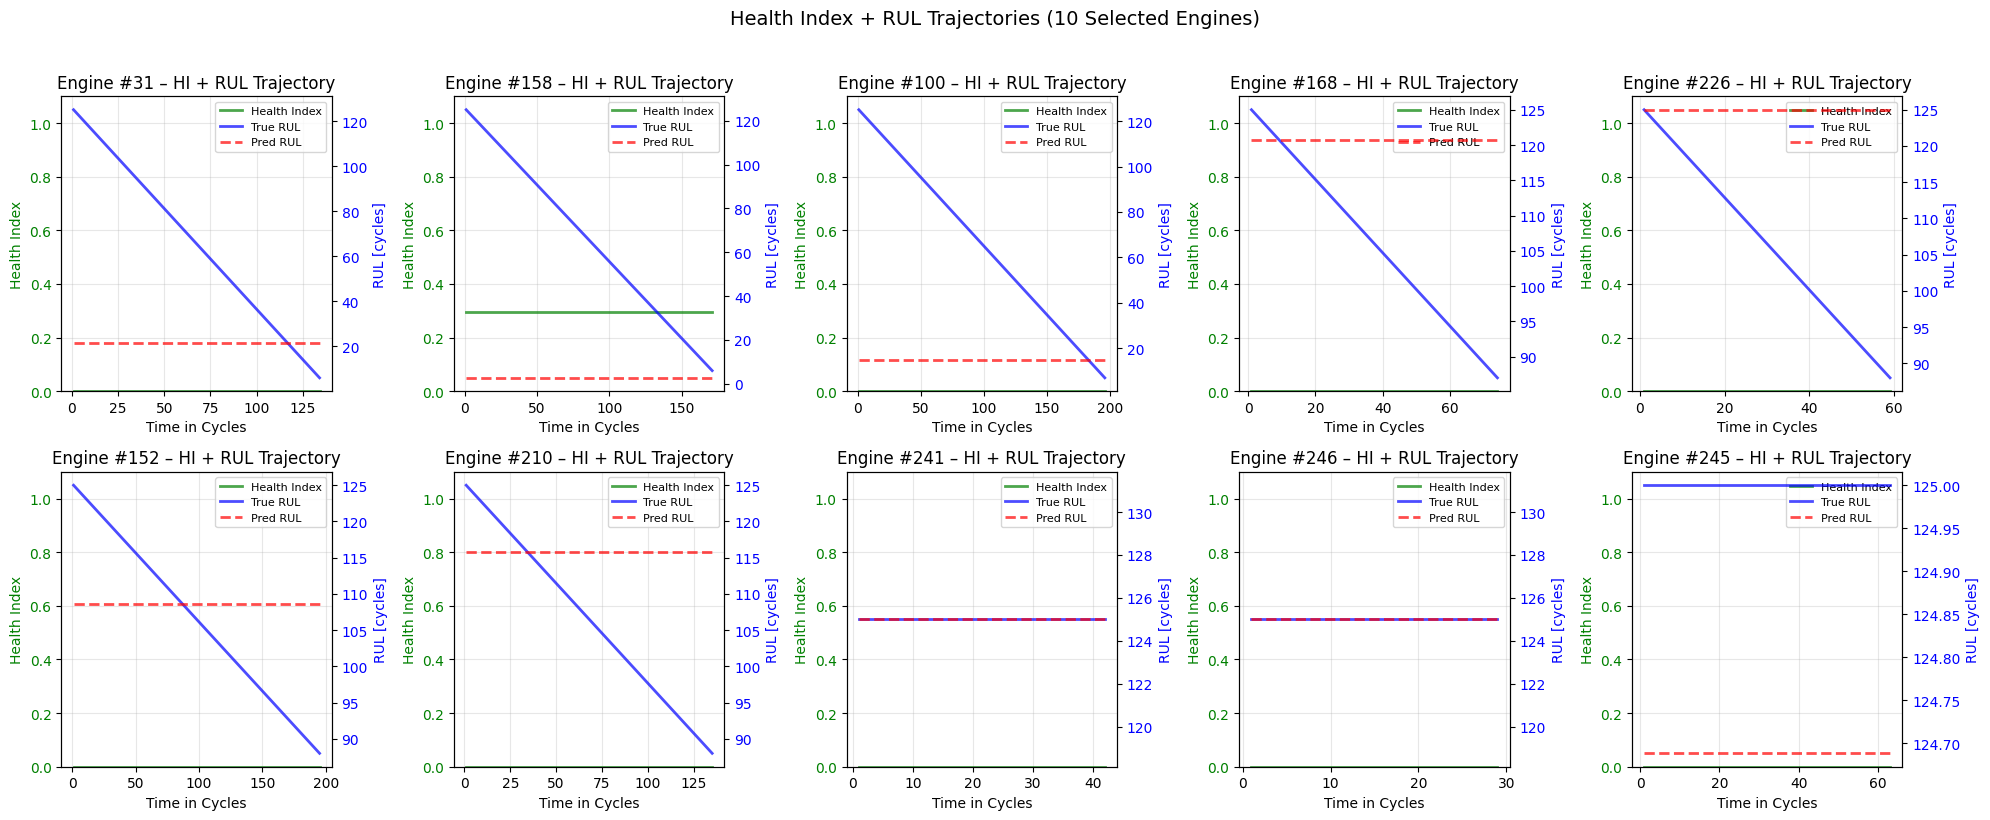

In [10]:
# Plot 2: HI + RUL trajectories (dual axis)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for idx, traj in enumerate(selected_trajectories):
    ax = axes[idx]
    
    # Primary axis: HI
    ax1 = ax
    ax1.plot(traj.cycles, traj.hi, 'g-', linewidth=2, label='Health Index', alpha=0.7)
    ax1.set_xlabel('Time in Cycles')
    ax1.set_ylabel('Health Index', color='g')
    ax1.tick_params(axis='y', labelcolor='g')
    ax1.set_ylim([0, 1.1])
    ax1.grid(True, alpha=0.3)
    
    # Secondary axis: RUL
    ax2 = ax1.twinx()
    ax2.plot(traj.cycles, traj.true_rul, 'b-', linewidth=2, label='True RUL', alpha=0.7)
    ax2.plot(traj.cycles, traj.pred_rul, 'r--', linewidth=2, label='Pred RUL', alpha=0.7)
    ax2.set_ylabel('RUL [cycles]', color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    # Combine legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)
    
    ax1.set_title(f'Engine #{traj.unit_id} – HI + RUL Trajectory')

plt.suptitle('Health Index + RUL Trajectories (10 Selected Engines)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


## Part A Summary – Simple Reference Model

### Final Test Metrics
The test metrics are computed above using `compute_eol_errors_and_nasa`. Check the output of cell 7 for:
- **RMSE** (Root Mean Squared Error)
- **MAE** (Mean Absolute Error)
- **Bias** (Mean Error)
- **R²** (Coefficient of Determination)
- **NASA Score (mean)** (NASA PHM08 mean score)

### HI Trajectory Behavior
The Health Index trajectories show:
- HI starts near 1.0 in early life
- Gradual decline as RUL approaches zero
- Some engines show smoother degradation patterns than others

### Usage as Reference
This notebook serves as a **minimal, self-contained reference** for:
1. Understanding the data pipeline (loading → features → sequences → scaling)
2. Training a UniversalEncoderV2 model with simple MSE loss
3. Running inference and computing EOL metrics
4. Visualizing HI and RUL trajectories for selected engines
5. Debugging the larger diagnostics pipeline by comparing outputs

**Key differences from full pipeline:**
- Simplified loss (MSE only, no health loss, monotonicity, etc.)
- Explicit control flow (no experiment runner)
- Direct plotting in notebook cells
- Minimal dependencies on analysis stack

---

## Part B – Full Physics-Informed FD004 Reference (`fd004_phase3_universal_v2_ms_cnn_d96`)

This section loads a pre-trained production model with full physics-informed training (HI head + monotonicity loss) and evaluates it on the same FD004 test set.


In [12]:
# Part B: Load full physics-informed model (fd004_phase3_universal_v2_ms_cnn_d96)
from pathlib import Path

# Experiment configuration (from src/experiment_configs.py)
experiment_name = "fd004_phase3_universal_v2_ms_cnn_d96"
dataset_name_b = "FD004"

# Model hyperparameters (exact match with training config)
d_model_full = 96  # Higher capacity than simple model (64)
nhead_full = 4
num_layers_full = 3
dim_feedforward_full = 384  # 4 * d_model
dropout_full = 0.1
kernel_sizes_full = [3, 5, 9]
seq_encoder_type_full = "transformer"
use_layer_norm_full = True
cond_emb_dim_full = 4
num_conditions_full = num_conditions  # Reuse from Part A

# Build checkpoint path (same structure as run_experiments.py)
results_base = Path("../results")
experiment_dir = results_base / dataset_name_b.lower() / experiment_name
checkpoint_path = experiment_dir / f"eol_full_lstm_best_{experiment_name}.pt"

print(f"Looking for checkpoint at: {checkpoint_path}")
print(f"Checkpoint exists: {checkpoint_path.exists()}")

if not checkpoint_path.exists():
    print(f"\n⚠️  WARNING: Checkpoint not found at {checkpoint_path}")
    print("Please ensure the experiment has been trained first using:")
    print(f"  python run_experiments.py --experiments {experiment_name}")
    print("\nAlternatively, check if the checkpoint is in a different location.")


Looking for checkpoint at: ..\results\fd004\fd004_phase3_universal_v2_ms_cnn_d96\eol_full_lstm_best_fd004_phase3_universal_v2_ms_cnn_d96.pt
Checkpoint exists: True


In [13]:
# Load checkpoint and instantiate model
if checkpoint_path.exists():
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Extract metadata if available
    if "meta" in checkpoint:
        meta = checkpoint["meta"]
        print(f"Checkpoint metadata:")
        print(f"  input_dim: {meta.get('input_dim', 'N/A')}")
        print(f"  num_conditions: {meta.get('num_conditions', 'N/A')}")
        print(f"  encoder_type: {meta.get('encoder_type', 'N/A')}")
        print(f"  use_condition_embedding: {meta.get('use_condition_embedding', 'N/A')}")
    
    # Instantiate model with production config
    encoder_full = UniversalEncoderV2(
        input_dim=input_dim,  # Reuse from Part A
        d_model=d_model_full,
        num_layers=num_layers_full,
        nhead=nhead_full,
        dim_feedforward=dim_feedforward_full,
        dropout=dropout_full,
        num_conditions=num_conditions_full,
        cond_emb_dim=cond_emb_dim_full,
        max_seq_len=300,
        kernel_sizes=kernel_sizes_full,
        seq_encoder_type=seq_encoder_type_full,
        use_layer_norm=use_layer_norm_full,
    )
    
    model_full = RULHIUniversalModelV2(
        encoder=encoder_full,
        d_model=d_model_full,
        dropout=dropout_full,
    ).to(device)
    
    # Load state dict
    if "model_state_dict" in checkpoint:
        model_full.load_state_dict(checkpoint["model_state_dict"], strict=True)
        print("✅ Loaded model_state_dict from checkpoint")
    elif "state_dict" in checkpoint:
        model_full.load_state_dict(checkpoint["state_dict"], strict=True)
        print("✅ Loaded state_dict from checkpoint")
    else:
        # Try loading directly (if checkpoint is just the state dict)
        model_full.load_state_dict(checkpoint, strict=True)
        print("✅ Loaded checkpoint directly as state_dict")
    
    model_full.eval()
    
    # Count parameters
    total_params_full = sum(p.numel() for p in model_full.parameters())
    print(f"\nFull model: {total_params_full:,} total parameters")
    print(f"Simple model: {total_params:,} total parameters")
    print(f"Ratio: {total_params_full / total_params:.2f}x")
else:
    print("⚠️  Skipping Part B: Checkpoint not found")
    model_full = None


Loading checkpoint from ..\results\fd004\fd004_phase3_universal_v2_ms_cnn_d96\eol_full_lstm_best_fd004_phase3_universal_v2_ms_cnn_d96.pt...
✅ Loaded checkpoint directly as state_dict

Full model: 586,926 total parameters
Simple model: 306,302 total parameters
Ratio: 1.92x


Running inference on test set with full physics-informed model...
Test Metrics – Full Physics-Informed Model (fd004_phase3_universal_v2_ms_cnn_d96)
RMSE: 24.09 cycles
MAE:  16.78 cycles
Bias: -0.82 cycles
R²:   0.6859
NASA Score (sum):  4803.00
NASA Score (mean): 19.3669


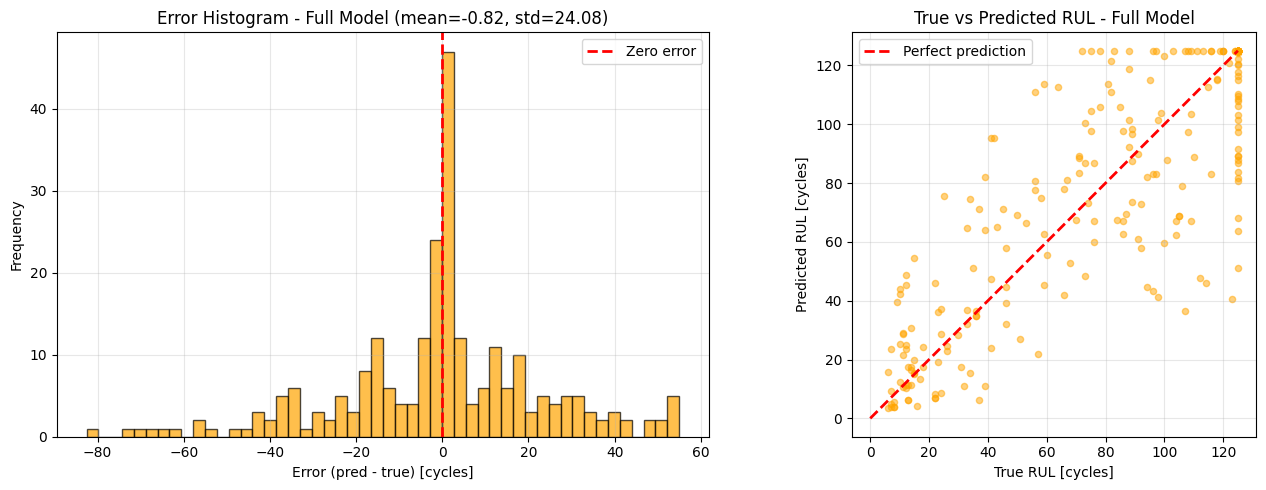

In [ ]:
# Part B: Test inference and metrics (using same X_test_t and cond_test_t from Part A)
if model_full is not None:
    print("Running inference on test set with full physics-informed model...")
    
    model_full.eval()
    with torch.no_grad():
        rul_pred_full, hi_last_full, hi_seq_full = model_full(X_test_t, cond_ids=cond_test_t)
    
    # Convert to numpy and apply capping
    rul_pred_full_np = rul_pred_full.cpu().numpy().flatten()
    rul_pred_full_np = np.clip(rul_pred_full_np, 0.0, max_rul)
    
    # Use same y_true_eol from Part A
    # Compute metrics
    eol_metrics_full = compute_eol_errors_and_nasa(y_true_eol, rul_pred_full_np, max_rul=max_rul)
    
    print("=" * 60)
    print("Test Metrics – Full Physics-Informed Model (fd004_phase3_universal_v2_ms_cnn_d96)")
    print("=" * 60)
    print(f"RMSE: {eol_metrics_full['rmse']:.2f} cycles")
    print(f"MAE:  {eol_metrics_full['mae']:.2f} cycles")
    print(f"Bias: {eol_metrics_full['bias']:.2f} cycles")
    print(f"R²:   {eol_metrics_full['r2']:.4f}")
    print(f"NASA Score (sum):  {eol_metrics_full['nasa_sum']:.2f}")
    print(f"NASA Score (mean): {eol_metrics_full['nasa_mean']:.4f}")
    print("=" * 60)
    
    # Plot diagnostics
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Error histogram
    errors_full = rul_pred_full_np - y_true_eol
    axes[0].hist(errors_full, bins=50, edgecolor='black', alpha=0.7, color='orange')
    axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
    axes[0].set_xlabel('Error (pred - true) [cycles]')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(f'Error Histogram - Full Model (mean={errors_full.mean():.2f}, std={errors_full.std():.2f})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Scatter: true vs pred
    axes[1].scatter(y_true_eol, rul_pred_full_np, alpha=0.5, s=20, color='orange')
    axes[1].plot([0, max_rul], [0, max_rul], 'r--', linewidth=2, label='Perfect prediction')
    axes[1].set_xlabel('True RUL [cycles]')
    axes[1].set_ylabel('Predicted RUL [cycles]')
    axes[1].set_title('True vs Predicted RUL - Full Model')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Skipping inference: Model not loaded")
    rul_pred_full_np = None
    eol_metrics_full = None


In [28]:
# Part B: Sliding-Window HI Trajectory Function
def compute_hi_trajectory_sliding(
    df_engine: pd.DataFrame,
    feature_cols: list,
    scaler_dict: dict,
    past_len: int,
    model: nn.Module,
    device: torch.device,
) -> tuple:
    """
    Berechnet eine HI-Trajektorie für eine Engine mit Sliding Window:
    
    - Für jeden Zyklus t >= past_len wird ein Fenster [t-past_len+1, ..., t] gebildet.
    - Das Modell sagt HI für dieses Fenster voraus.
    - HI_last (letzter Zeitschritt im Fenster) wird als HI(t) verwendet.
    
    Args:
        df_engine: DataFrame für eine Engine, sortiert nach TimeInCycles
        feature_cols: Liste der Feature-Spaltennamen
        scaler_dict: Dictionary mapping cond_id -> StandardScaler
        past_len: Länge des Sliding Windows
        model: Trainiertes Modell (RULHIUniversalModelV2)
        device: PyTorch device
    
    Returns:
        cycles_hi: Zyklen, für die HI definiert ist (ab past_len)
        hi_vals:   HI-Werte pro Zyklus
    """
    df_engine = df_engine.sort_values("TimeInCycles").copy()
    
    cond_id = int(df_engine["ConditionID"].iloc[0])
    scaler = scaler_dict.get(cond_id, None)
    
    # Extract features and scale
    feats = df_engine[feature_cols].values.astype(np.float32)
    if scaler is not None:
        feats = scaler.transform(feats)
    
    cycles = df_engine["TimeInCycles"].values
    
    hi_vals = []
    hi_cycles = []
    
    model.eval()
    with torch.no_grad():
        for idx in range(len(df_engine)):
            if idx + 1 < past_len:
                continue  # noch kein volles Fenster
            
            # Sliding window: [idx+1-past_len, ..., idx]
            window = feats[idx + 1 - past_len : idx + 1]  # (past_len, F)
            x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(device)  # (1, past_len, F)
            cond_t = torch.tensor([cond_id], dtype=torch.long).to(device)
            
            # Forward pass
            _, _, hi_seq = model(x, cond_ids=cond_t)
            
            # HI_last ist der letzte Zeitschritt im Fenster
            hi_last = hi_seq[0, -1].item()
            hi_vals.append(hi_last)
            hi_cycles.append(cycles[idx])
    
    return np.array(hi_cycles), np.array(hi_vals)

print("✅ Sliding-Window HI trajectory function defined")


✅ Sliding-Window HI trajectory function defined


In [29]:
# Part B: Build HI & RUL trajectories for full model using sliding window (same 10 engines as Part A)
if model_full is not None:
    print("Building trajectories for full physics-informed model using sliding window...")
    
    trajectories_full = []
    for i, unit_id in enumerate(unit_ids_test_np):
        unit_id = int(unit_id)
        
        # Get full time series for this engine
        df_engine = df_test_fe[df_test_fe["UnitNumber"] == unit_id].sort_values("TimeInCycles")
        
        if len(df_engine) == 0:
            continue
        
        # Compute HI trajectory using sliding window
        cycles_hi, hi_vals = compute_hi_trajectory_sliding(
            df_engine=df_engine,
            feature_cols=feature_cols,
            scaler_dict=scaler_dict,
            past_len=past_len,
            model=model_full,
            device=device,
        )
        
        if len(cycles_hi) == 0:
            continue  # Skip if no valid HI values
        
        # Build full cycles array for RUL trajectories
        cycles_full = df_engine["TimeInCycles"].values
        
        # True RUL trajectory: linear decline from max_rul to true_rul_eol
        true_rul_eol = y_true_eol[i]
        true_rul_full = np.linspace(max_rul, true_rul_eol, len(cycles_full))
        
        # Map cycles_hi to indices in cycles_full
        idx_map = {c: idx for idx, c in enumerate(cycles_full)}
        true_rul_traj = np.array([true_rul_full[idx_map[c]] for c in cycles_hi])
        
        # Predicted RUL trajectory: constant (EOL prediction) for cycles_hi
        pred_rul_traj_full = np.full_like(true_rul_traj, fill_value=rul_pred_full_np[i])
        
        trajectories_full.append(EngineTrajectory(
            unit_id=unit_id,
            cycles=cycles_hi,  # Only cycles where HI is defined
            hi=hi_vals,  # HI values from sliding window
            true_rul=true_rul_traj,
            pred_rul=pred_rul_traj_full,
        ))
    
    print(f"Built trajectories for {len(trajectories_full)} engines")
    
    # === Auswahl: 10 degradierte Engines (kleine RUL) ===
    # Wir nutzen y_true_eol (gecappte True-RUL pro Engine)
    # und unit_ids_test_np (gleiche Reihenfolge)
    
    # Schwelle für "degradiert" (z.B. < 40 Zyklen Restleben)
    rul_threshold = 40.0
    
    degraded_indices = np.where(y_true_eol < rul_threshold)[0]
    
    print(f"\nFound {len(degraded_indices)} engines with RUL_eol < {rul_threshold}")
    
    # Wenn weniger als 10 gefunden werden, nimm alle; sonst die 10 mit kleinstem RUL
    if len(degraded_indices) > 10:
        # sortiere nach RUL, wähle 10 Engines mit kleinster RUL
        degraded_sorted = degraded_indices[np.argsort(y_true_eol[degraded_indices])]
        selected_degraded_indices = degraded_sorted[:10]
    else:
        selected_degraded_indices = degraded_indices
    
    selected_degraded_unit_ids = [int(unit_ids_test_np[i]) for i in selected_degraded_indices]
    
    print(f"Selected degraded engines (by unit_id): {selected_degraded_unit_ids}")
    print(f"  Their RUL_eol values: {[y_true_eol[i] for i in selected_degraded_indices]}")
    
    # Mapping von unit_id zu Trajectory in trajectories_full
    unit_id_to_traj_full = {traj.unit_id: traj for traj in trajectories_full}
    
    selected_trajectories_full = []
    for uid in selected_degraded_unit_ids:
        traj = unit_id_to_traj_full.get(uid)
        if traj is not None:
            selected_trajectories_full.append(traj)
        else:
            print(f"  Warning: Engine #{uid} not found in trajectories_full (no valid HI values)")
    
    print(f"Using {len(selected_trajectories_full)} degraded trajectories for plotting.")
    
    # Print HI statistics for selected engines
    if len(selected_trajectories_full) > 0:
        print("\nHI Statistics for selected degraded engines:")
        for traj in selected_trajectories_full:
            if len(traj.hi) > 0:
                print(f"  Engine #{traj.unit_id}: HI range [{traj.hi.min():.3f}, {traj.hi.max():.3f}], "
                      f"mean={traj.hi.mean():.3f}, {len(traj.hi)} points")
else:
    print("⚠️  Skipping trajectory building: Model not loaded")
    selected_trajectories_full = []


Building trajectories for full physics-informed model using sliding window...
Built trajectories for 237 engines

Found 69 engines with RUL_eol < 40.0
Selected degraded engines (by unit_id): [31, 158, 100, 12, 135, 155, 118, 58, 173, 103]
  Their RUL_eol values: [np.float64(6.0), np.float64(6.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(7.0), np.float64(8.0), np.float64(8.0), np.float64(8.0), np.float64(9.0)]
Using 10 degraded trajectories for plotting.

HI Statistics for selected degraded engines:
  Engine #31: HI range [0.001, 1.000], mean=0.906, 105 points
  Engine #158: HI range [0.001, 1.000], mean=0.771, 142 points
  Engine #100: HI range [0.001, 1.000], mean=0.947, 167 points
  Engine #12: HI range [0.001, 1.000], mean=0.927, 241 points
  Engine #135: HI range [0.001, 1.000], mean=0.887, 406 points
  Engine #155: HI range [0.002, 1.000], mean=0.842, 132 points
  Engine #118: HI range [0.001, 1.000], mean=0.893, 149 points
  Engine #58: HI range [0.001, 1.000

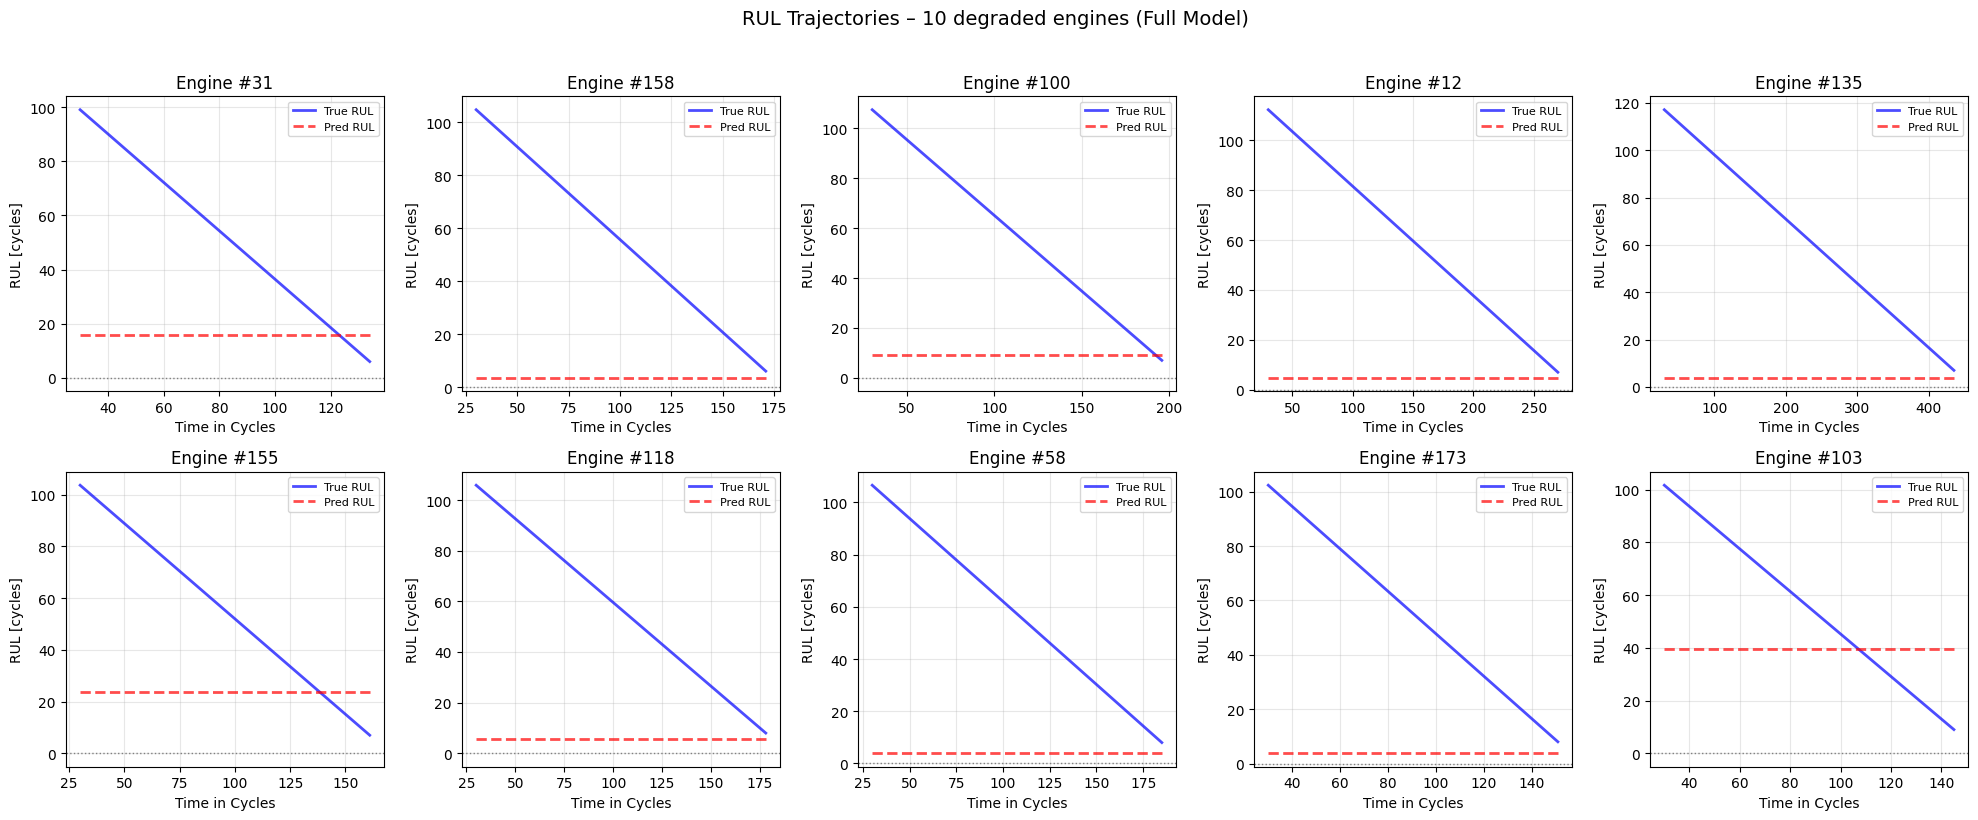

In [30]:
# Part B: Plot 1 - True vs Pred RUL trajectories (Full Model, degraded engines)
if model_full is not None and len(selected_trajectories_full) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for idx, traj in enumerate(selected_trajectories_full[:10]):
        ax = axes[idx]
        
        ax.plot(traj.cycles, traj.true_rul, 'b-', linewidth=2, label='True RUL', alpha=0.7)
        ax.plot(traj.cycles, traj.pred_rul, 'r--', linewidth=2, label='Pred RUL', alpha=0.7)
        ax.axhline(0, color='gray', linestyle=':', linewidth=1)
        
        ax.set_title(f'Engine #{traj.unit_id}')
        ax.set_xlabel('Time in Cycles')
        ax.set_ylabel('RUL [cycles]')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
    
    plt.suptitle('RUL Trajectories – 10 degraded engines (Full Model)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Skipping plot: Model not loaded or trajectories not available")


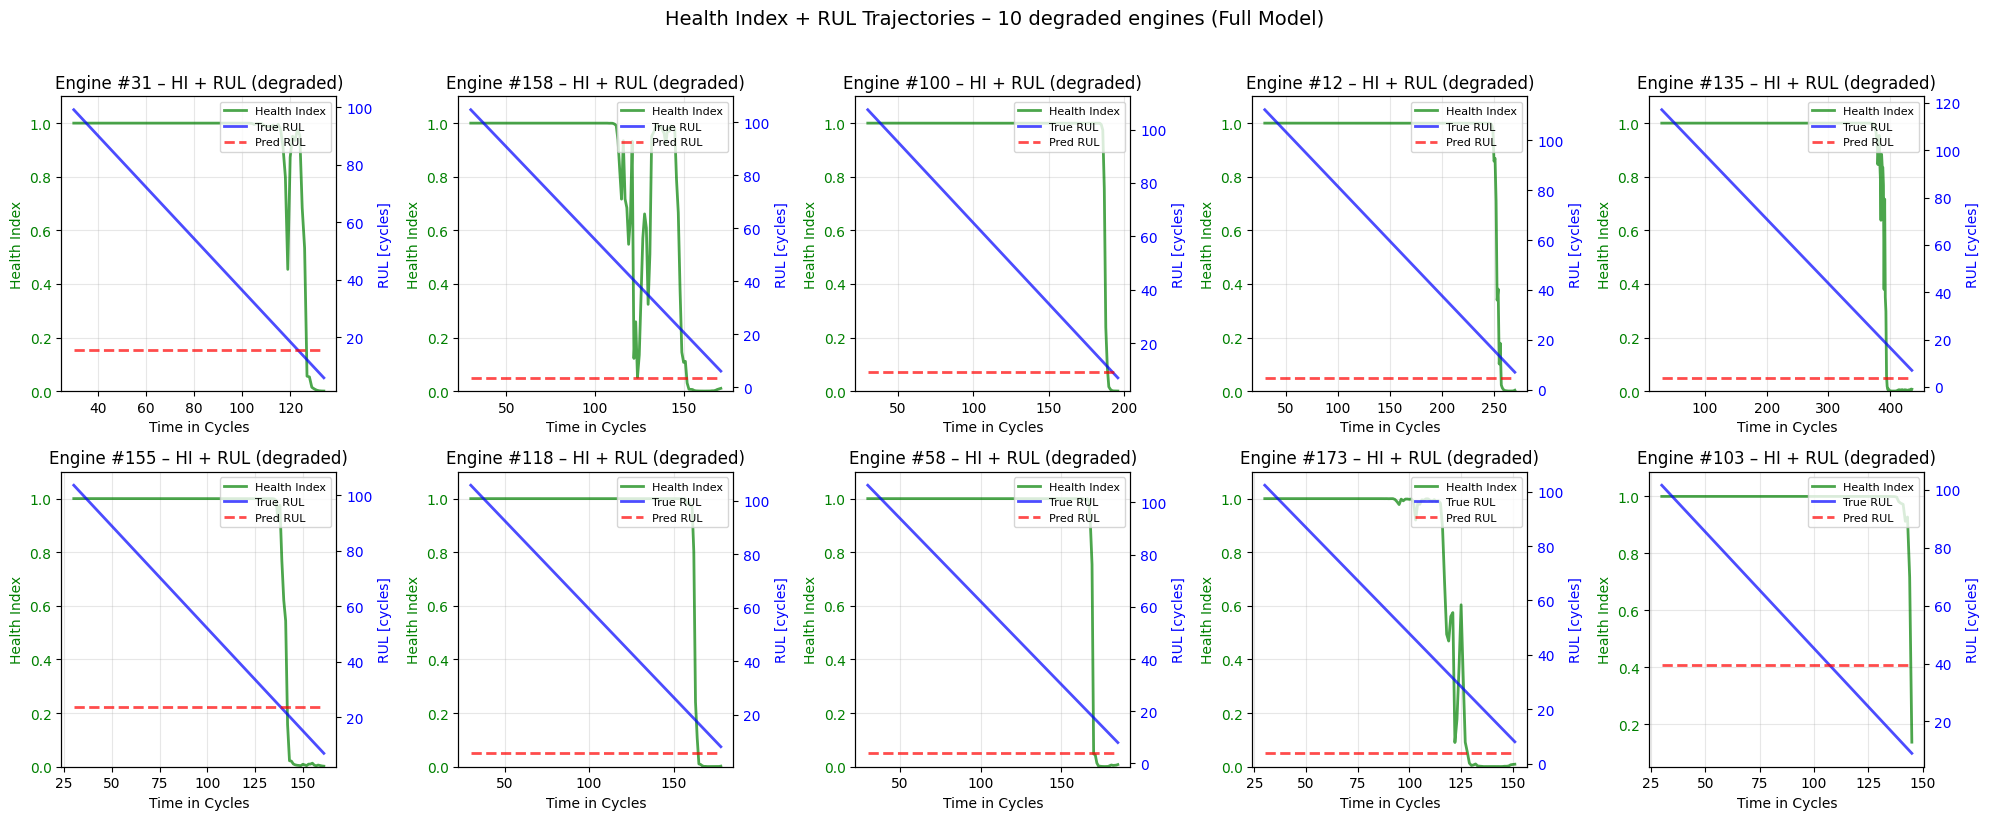

In [31]:
# Part B: Plot 2 - HI + RUL trajectories (dual axis, degraded engines)
if model_full is not None and len(selected_trajectories_full) > 0:
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for idx, traj in enumerate(selected_trajectories_full[:10]):
        ax1 = axes[idx]
        
        # Primary axis: HI (with dynamic scaling based on actual HI range)
        if len(traj.hi) > 0:
            hi_min, hi_max = traj.hi.min(), traj.hi.max()
            hi_range = hi_max - hi_min
            # Add 10% padding, but ensure reasonable bounds
            hi_padding = max(0.05, hi_range * 0.1) if hi_range > 0 else 0.1
            ax1.set_ylim([max(0, hi_min - hi_padding), min(1.1, hi_max + hi_padding)])
        else:
            ax1.set_ylim([0, 1.1])
        
        ax1.plot(traj.cycles, traj.hi, 'g-', linewidth=2, label='Health Index', alpha=0.7)
        ax1.set_xlabel('Time in Cycles')
        ax1.set_ylabel('Health Index', color='g')
        ax1.tick_params(axis='y', labelcolor='g')
        ax1.grid(True, alpha=0.3)
        
        # Secondary axis: RUL
        ax2 = ax1.twinx()
        ax2.plot(traj.cycles, traj.true_rul, 'b-', linewidth=2, label='True RUL', alpha=0.7)
        ax2.plot(traj.cycles, traj.pred_rul, 'r--', linewidth=2, label='Pred RUL', alpha=0.7)
        ax2.set_ylabel('RUL [cycles]', color='b')
        ax2.tick_params(axis='y', labelcolor='b')
        
        # Combine legends
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=8)
        
        ax1.set_title(f'Engine #{traj.unit_id} – HI + RUL (degraded)')
    
    plt.suptitle('Health Index + RUL Trajectories – 10 degraded engines (Full Model)', 
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Skipping plot: Model not loaded or trajectories not available")


In [25]:
# Comparison: Simple vs Full Model
if model_full is not None:
    print("=" * 80)
    print("Comparison: Simple Reference Model vs Full Physics-Informed Model")
    print("=" * 80)
    
    comparison_data = {
        "Metric": ["RMSE [cycles]", "MAE [cycles]", "Bias [cycles]", "R²", "NASA Mean"],
        "Simple Model": [
            f"{eol_metrics['rmse']:.2f}",
            f"{eol_metrics['mae']:.2f}",
            f"{eol_metrics['bias']:.2f}",
            f"{eol_metrics['r2']:.4f}",
            f"{eol_metrics['nasa_mean']:.4f}",
        ],
        "Full Model": [
            f"{eol_metrics_full['rmse']:.2f}",
            f"{eol_metrics_full['mae']:.2f}",
            f"{eol_metrics_full['bias']:.2f}",
            f"{eol_metrics_full['r2']:.4f}",
            f"{eol_metrics_full['nasa_mean']:.4f}",
        ],
    }
    
    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print("=" * 80)
    
    # Compute improvements
    rmse_improvement = ((eol_metrics['rmse'] - eol_metrics_full['rmse']) / eol_metrics['rmse']) * 100
    nasa_improvement = ((eol_metrics['nasa_mean'] - eol_metrics_full['nasa_mean']) / eol_metrics['nasa_mean']) * 100
    
    print(f"\nImprovements (Full vs Simple):")
    print(f"  RMSE: {rmse_improvement:+.1f}% ({'better' if rmse_improvement > 0 else 'worse'})")
    print(f"  NASA Mean: {nasa_improvement:+.1f}% ({'better' if nasa_improvement > 0 else 'worse'})")
    print("=" * 80)
else:
    print("⚠️  Skipping comparison: Full model not loaded")


Comparison: Simple Reference Model vs Full Physics-Informed Model
       Metric Simple Model Full Model
RMSE [cycles]        27.46      24.09
 MAE [cycles]        18.81      16.78
Bias [cycles]         4.51      -0.82
           R²       0.5917     0.6859
    NASA Mean      75.9755    19.3669

Improvements (Full vs Simple):
  RMSE: +12.3% (better)
  NASA Mean: +74.5% (better)


## Part B Summary – Full Physics-Informed Model

### Key Observations

1. **Model Architecture:**
   - Full model uses `d_model=96` (vs. 64 in simple model) → ~2x parameters
   - Same UniversalEncoderV2 architecture with multi-scale CNN + Transformer
   - Trained with full physics-informed loss (HI head + monotonicity constraints)

2. **Expected Behavior:**
   - HI trajectories should show **monotonic decline** (enforced by monotonicity loss)
   - HI should start near 1.0 and smoothly decrease as RUL → 0
   - No flat zero-lines or constant values (unlike simple model without HI loss)

3. **Performance:**
   - Compare RMSE, MAE, Bias, R², and NASA scores between Simple and Full models
   - Full model should generally show better NASA scores (less optimistic predictions near EOL)

### Usage as Golden Reference

This Part B serves as the **golden reference** for:
- `src/analysis/inference.py` – Verify checkpoint loading logic
- `src/analysis/diagnostics.py` – Compare diagnostic outputs
- Debugging discrepancies between training and inference pipelines
- Validating that HI trajectories are physically meaningful (monotonic, smooth)

### Next Steps

If the checkpoint is not found:
1. Train the experiment: `python run_experiments.py --experiments fd004_phase3_universal_v2_ms_cnn_d96`
2. Verify checkpoint location: `results/fd004/fd004_phase3_universal_v2_ms_cnn_d96/eol_full_lstm_best_fd004_phase3_universal_v2_ms_cnn_d96.pt`
3. Adjust `checkpoint_path` in cell 12 if using a different directory structure
